In [1]:
import numpy as np
import pandas as pd

import digits as dg
import net as nn

In [2]:
DATA = {
    'all': dg.extractInputAndOutput(dg.getDigits()),
    'training': dg.extractInputAndOutput(dg.getDigits(kinds={'normal', 'klein', 'digital', 'digital-klein'})),
    'test': dg.extractInputAndOutput(dg.getDigits(kinds={'evag'})),
}

In [3]:
numOfHiddens = {5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90}
numOfNets = 100

input = DATA['all']['input']
output = DATA['all']['output']

initNets = {
    'net': [],
    'numOfHidden': [],
    'error': []
}

for numOfHidden in numOfHiddens:
    np.random.seed(0)  # to create reproduceable results

    for _ in range(numOfNets):
        net = nn.init(35, numOfHidden, 10)
        error = nn.calcBatchError(net, input, output)

        initNets['net'].append(net)
        initNets['numOfHidden'].append(numOfHidden)
        initNets['error'].append(error)

INIT_NETS = pd.DataFrame(initNets)

,error
numOfHidden,
35,0.143571
70,0.143792
20,0.162996
25,0.166742
15,0.170721
30,0.176098
5,0.183089
10,0.187878
60,0.188517


<AxesSubplot:xlabel='numOfHidden', ylabel='error'>

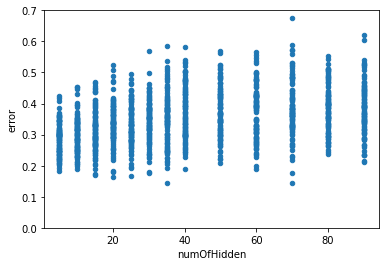

In [4]:
display(INIT_NETS.groupby('numOfHidden').min('error').sort_values('error'))
INIT_NETS.plot.scatter('numOfHidden', 'error', ylim=(0, 0.7))

In [5]:
numOfHiddens = {35, 70, 20, 25, 15, 30, 5}
epoches = 1000
learnRate = 0.1

inputTrain = DATA['training']['input']
outputTrain = DATA['training']['output']

inputTest = DATA['test']['input']
outputTest = DATA['test']['output']

trainHistory = {
    'net': [],
    'numOfHidden': [],
    'errorTrain': [],
    'errorTest': [],
}

for numOfHidden in numOfHiddens:
    net = INIT_NETS[INIT_NETS.numOfHidden == numOfHidden].nsmallest(
        1, 'error').iloc[0].net

    for i in range(epoches):
        net = nn.trainBatch(net, inputTrain, outputTrain, learnRate)
        errorTrain = nn.calcBatchError(net, inputTrain, outputTrain)
        errorTest = nn.calcBatchError(net, inputTest, outputTest)

        trainHistory['net'].append(net)
        trainHistory['numOfHidden'].append(numOfHidden)
        trainHistory['errorTrain'].append(errorTrain)
        trainHistory['errorTest'].append(errorTest)

TRAIN_HIDDEN = pd.DataFrame(trainHistory)

,errorTrain,errorTest
numOfHidden,,
35,0.084060,0.086994
30,0.086010,0.091076
15,0.086051,0.086862
70,0.088598,0.091938
25,0.089231,0.086783
5,0.091049,0.092798
20,0.091201,0.089823


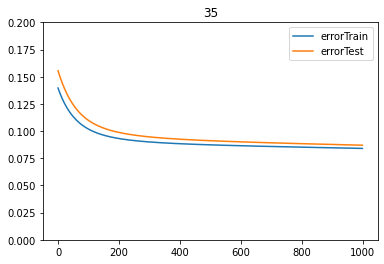

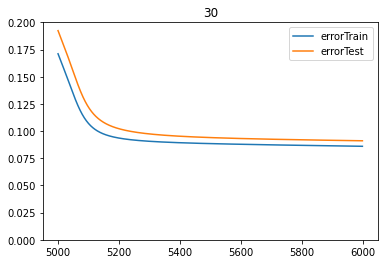

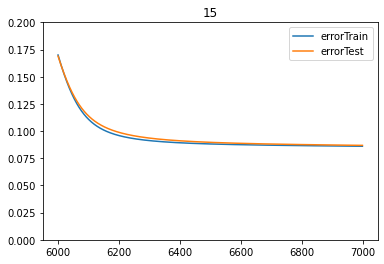

In [6]:
display(TRAIN_HIDDEN.groupby('numOfHidden').min(
    'errorTrain').sort_values('errorTrain'))
for numOfHidden in {35, 30, 15}:
    TRAIN_HIDDEN[TRAIN_HIDDEN.numOfHidden == numOfHidden].plot.line(
        y={'errorTrain', 'errorTest'}, ylim=(0, 0.2), title=numOfHidden)

In [7]:
startNet = INIT_NETS[INIT_NETS.numOfHidden == 15].iloc[0].net
learnRates = {0.1, 0.01, 0.001}
epoches = 10000

inputTrain = DATA['training']['input']
outputTrain = DATA['training']['output']

inputTest = DATA['test']['input']
outputTest = DATA['test']['output']

trainHistory = {
    'net': [],
    'learnRate': [],
    'errorTrain': [],
    'errorTest': [],
}

for learnRate in learnRates:
    net = startNet

    for i in range(epoches):
        net = nn.trainBatch(net, inputTrain, outputTrain, learnRate)
        errorTrain = nn.calcBatchError(net, inputTrain, outputTrain)
        errorTest = nn.calcBatchError(net, inputTest, outputTest)

        trainHistory['net'].append(net)
        trainHistory['learnRate'].append(learnRate)
        trainHistory['errorTrain'].append(errorTrain)
        trainHistory['errorTest'].append(errorTest)

TRAIN_LR = pd.DataFrame(trainHistory)

,errorTrain,errorTest
learnRate,,
0.100,0.068013,0.063886
0.010,0.087907,0.085005
0.001,0.185748,0.190018


learnRate
0.001    AxesSubplot(0.125,0.125;0.775x0.755)
0.010    AxesSubplot(0.125,0.125;0.775x0.755)
0.100    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

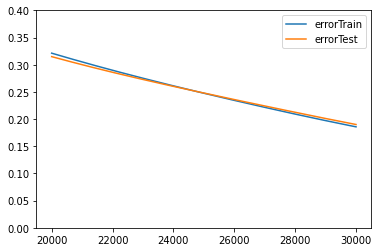

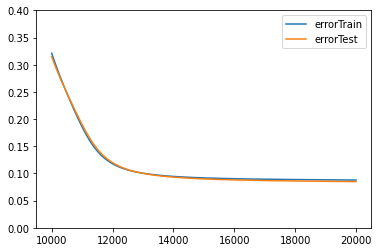

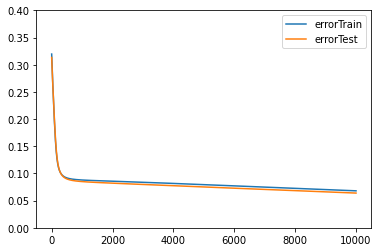

In [8]:
display(TRAIN_LR.groupby('learnRate').min(
    'errorTrain').sort_values('errorTrain'))
TRAIN_LR.groupby('learnRate').plot.line(
    y={'errorTrain', 'errorTest'}, ylim=(0, 0.4))

In [9]:
learnRate = 0.1
targetError = 0.05

inputTrain = DATA['training']['input']
outputTrain = DATA['training']['output']

inputTest = DATA['test']['input']
outputTest = DATA['test']['output']

trainHistory = TRAIN_LR[TRAIN_LR.learnRate == learnRate].drop('learnRate', 1)
net = trainHistory.iloc[-1].net
error = nn.calcBatchError(net, inputTrain, outputTrain)

while error > targetError:
    net = nn.trainBatch(net, inputTrain, outputTrain, learnRate)
    errorTrain = nn.calcBatchError(net, inputTrain, outputTrain)
    errorTest = nn.calcBatchError(net, inputTest, outputTest)

    trainHistory = trainHistory.append({
        'net': net,
        'errorTrain': errorTrain,
        'errorTest': errorTest,
    }, ignore_index=True)

    error = errorTrain

TRAIN_FINAL = trainHistory

In [10]:
TRAIN_FINAL.describe()

,errorTrain,errorTest
count,18644.000000,18644.000000
mean,0.070959,0.067243
std,0.018867,0.019201
min,0.049999,0.047016
25%,0.059022,0.055253
50%,0.069571,0.065437
75%,0.080162,0.075853
max,0.319617,0.313364
